In [33]:
# uni_D83AE5_uni (Baseline)
#  {"Logloss": 0.02929905326872508, "ROCAUC": 0.9784653910998551}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import gamma, kstest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_auc_score, 
    roc_curve, 
    auc
)
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')  # Use this line to suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

training_data = pd.read_csv('training_data.csv')
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_submission_example = pd.read_csv('data_submission_example.csv')

In [34]:
training_data.fillna(0, inplace=True)
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [35]:
lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]
date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [36]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [37]:
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['DAYS_TO_END'] = (pd.Timestamp("2020-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_END'] = training_data['DAYS_TO_END'] / 365
training_data['DAYS_TO_2018'] = (pd.Timestamp("2018-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_2018'] = training_data['DAYS_TO_2018'] / 365

In [38]:
training_data['TIME_TO_MATURITY_DAYS'] = (training_data['CONTRACT_MATURITY_DATE']-training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
training_data['2020_OR_MATURITY'] = np.minimum(training_data['TIME_TO_MATURITY_DAYS'], training_data['DAYS_TO_END'])
training_data['2020_OR_MATURITY_YEARS'] = training_data['2020_OR_MATURITY'] / 365

In [39]:
def create_binary_target_column(dataframe, column_name, event, day_diff_upper_limit):
    dataframe[column_name] = np.where(
        (dataframe['TARGET_EVENT'] == event) & 
        (dataframe['DAY_DIFF'] <= day_diff_upper_limit) & 
        (dataframe['DAY_DIFF'] >= 0), 
        1, 
        0
    )

timeframes = {
    'TARGET_EVENT_BINARY_2Y': 730,
    'TARGET_EVENT_BINARY_1Y': 365,
    'TARGET_EVENT_BINARY_6M': 365//2,
}

for column_name, days in timeframes.items():
    create_binary_target_column(training_data, column_name, 'K', days)


# target_event_binary_columns = []
# for i in range(6):
#     start_day = 273 + i * 30
#     column_header = 'TARGET_EVENT_BINARY_' + str(start_day) + 'D'
#     training_data[column_header] = np.where(
#         (training_data['TARGET_EVENT'] == 'K') & 
#         (training_data['DAY_DIFF'] <= start_day) & 
#         (training_data['DAY_DIFF'] >= 0), 
#         1, 
#         0
#     )
#     target_event_binary_columns.append(column_header)

# training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [40]:
print(training_data['TARGET_EVENT_BINARY'].value_counts())
print(training_data['TARGET_EVENT_BINARY_2Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_1Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_6M'].value_counts())

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64
TARGET_EVENT_BINARY_2Y
0    1591751
1       9912
Name: count, dtype: int64
TARGET_EVENT_BINARY_1Y
0    1596927
1       4736
Name: count, dtype: int64
TARGET_EVENT_BINARY_6M
0    1601267
1        396
Name: count, dtype: int64


In [41]:
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE', 'DAYS', 'YEARS', 'MATURITY', 'DAY']

X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [42]:
X_columns.append('TIME_TO_MATURITY_DAYS')

In [43]:
# for var in date_variables:
#     training_data[var+ '_JULIAN'] = pd.to_datetime(training_data[var], origin='julian', unit='D')

# training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN']).dt.days

# year_2018_date = pd.Timestamp('2018-01-01')
# training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - year_2018_date).dt.days
# training_data['ADJUSTED_TIME_TO_MATURITY'] = training_data['TIME_TO_MATURITY'].apply(lambda x: max(min(730, x),0))

In [44]:
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)
interest_type_dummies = pd.get_dummies(training_data['CONTRACT_TYPE_OF_INTEREST_REPAYMENT'], prefix='INTEREST_TYPE', drop_first=True)
mortgage_type_dummies =  pd.get_dummies(training_data['CONTRACT_MORTGAGE_TYPE'], prefix='MORTGAGE_TYPE', drop_first=True)
# CONTRACT_MORTGAGE_TYPE
# CONTRACT_LOAN_CONTRACT_TYPE
# CONTRACT_FREQUENCY_TYPE
training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies,interest_type_dummies,mortgage_type_dummies ], axis=1)
# training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies, ], axis=1)

X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)
X_columns.extend(interest_type_dummies.columns)
X_columns.extend(mortgage_type_dummies.columns)

In [45]:
import numpy as np
import numpy_financial as npf
import pandas as pd

# Assuming training_data is your DataFrame and it's already defined

# Define a function to calculate the monthly payment
def calculate_monthly_payment(row):
    annual_interest_rate = row['CONTRACT_INTEREST_RATE'] / 100  # Convert percentage to decimal
    monthly_interest_rate = annual_interest_rate / 12
    term_in_months = ((pd.to_datetime(row['CONTRACT_MATURITY_DATE_DATETIME'], format='%d/%m/%Y') - 
                       pd.to_datetime(row['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'], format='%d/%m/%Y'))).days/30
    # print(term_in_months.days/30)
    principal = row['CONTRACT_LOAN_AMOUNT']
    monthly_payment = npf.pmt(monthly_interest_rate, term_in_months, -principal)
    return monthly_payment

# Apply the function to the DataFrame to create a new 'MONTHLY_PAYMENT' column
training_data['MONTHLY_PAYMENT'] = training_data.apply(calculate_monthly_payment, axis=1)
training_data['MONTHLY_PAYMENT'] = training_data['MONTHLY_PAYMENT'].apply(lambda x: 0 if not np.isfinite(x) else x)

# # Extend your features list with the new 'MONTHLY_PAYMENT' column
X_columns.extend(['MONTHLY_PAYMENT'])

# # If you also need to log-normalize the monthly payment, add it to the lognormal_variables list
lognormal_variables.extend(['MONTHLY_PAYMENT'])

# # Now, the rest of your feature engineering code remains the same.


In [46]:
# training_data['TOTAL_MONTHLY_AMOUNT'] = training_data.groupby('BORROWER_ID')['MONTHLY_PAYMENT'].transform('sum')
# X_columns.extend(['TOTAL_MONTHLY_AMOUNT'])
# lognormal_variables.extend(['TOTAL_MONTHLY_AMOUNT'])

In [47]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']

X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [48]:
threshold = 0.85
correlation_matrix = training_data[X_columns].corr()
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'FREQ_TYPE_2f88e16c', 'CONTRACT_REFINANCED', 'BORROWER_COUNTRY'}


In [49]:
def default_percentage_generator_2016(df, percentage, target):
    df_copy = df.copy()
    df_filtered = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_mean = df_filtered[target].mean()
    print(f"Mean in year {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=42).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

def default_percentage_generator_2017(df, percentage, target):
    df_copy = df.copy()
    df_filtered = df_copy[(df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') &
                          (df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')] 
    df_mean = df_filtered[target].mean()
    print(f"Mean in year 2017 {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=42).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

def default_percentage_generator_2018(df, percentage, target):
    df_copy = df.copy()
    df_filtered = df_copy[(df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01')] 
    df_mean = df_filtered[target].mean()
    print(f"Mean in year 2018: {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=42).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

# new_df = default_percentage_generator_2018(training_data, 1.48/100, 'TARGET_EVENT_BINARY_2Y')

In [50]:
# training_data.head(5)['LOGISTIC_REG']

In [51]:
def calculate_probabilities(data, column, time_factor):
    lambdas = -np.log(1 - data[column]) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y
def calculate_probabilities_vec(data, time_factor):
    lambdas = -np.log(1 - data) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y
def calculate_probabilities_new(data, column, time_factor, extra_time):
    lambdas = -np.log(1 - data[column]) / 2
    probs = 1 - np.exp(-(time_factor+extra_time) * lambdas)
    return probs
# def adjust_probabilities(data, factor):
#     odds = data / (1 - data)  # Convert probabilities to odds
#     new_odds = odds * factor  # Scale the odds by the factor

#     # Convert the new odds back to probabilities
#     new_probabilities = new_odds / (1 + new_odds)
#     return new_probabilities


In [52]:
# training_data.head(5)['LOGISTIC_REG']/(1-training_data.head(5)['LOGISTIC_REG'])

In [53]:
# adjust_probabilities(training_data.head(10)['LOGISTIC_REG'],  1).mean()

In [78]:
from sklearn.calibration import CalibratedClassifierCV

def train_and_predict_two_halves(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), augment_distribution=False,calibrate=False, default_proba=[2,2,2]):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    if augment_distribution:
        df_filtered = default_percentage_generator_2016(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']

    
    X_scaled = scaler.fit_transform(df[variables])
    X_filtered = scaler.transform(df_filtered[variables])

    y = df[target]
    y_filtered = df_filtered[target]
    if calibrate:
        model = CalibratedClassifierCV(base_estimator=model, method='isotonic', )

    model.fit(X_filtered, y_filtered)
    

    print("Logloss:")
    print(log_loss(y, model.predict_proba(X_scaled)))
    proba = model.predict_proba(X_scaled)[:, 1]

    return proba

In [55]:
# training_data['DAY_DIFF'].value_counts()    

In [56]:
def defaulted(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), augment_distribution=False,default_proba=[2,2,2]):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    if augment_distribution:
        df_filtered = default_percentage_generator_2016(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']

    defaults = df_filtered[df_filtered[target]==1]
    defaults['NEW_TARGET'] = 0
    defaults.loc[defaults['DAY_DIFF'] <= 730, 'NEW_TARGET'] = 1

    # print(defaults['DAY_DIFF'].value_counts())
    # print(defaults['NEW_TARGET'].value_counts())

    
    
    X_scaled = scaler.fit_transform(df[variables])
    X_filtered = scaler.transform(defaults[variables])

    y = df[target]
    y_filtered = defaults['NEW_TARGET']
    model.fit(X_filtered, y_filtered)
    # print("Logloss:")
    # print(log_loss(y, model.predict_proba(X_scaled)))
    proba = model.predict_proba(X_scaled)[:, 1]

    return proba

In [91]:
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler(), augment_distribution=False):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    if augment_distribution:
        df_filtered = default_percentage_generator_2016(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_filtered = df_filtered.reset_index(drop=True)

    X_scaled = scaler.fit_transform(df_filtered[variables])

    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df_filtered[target]
    model = sm.Logit(y, X).fit()
    print(model.summary())
    p_values = model.pvalues
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [58]:
def combined_probability(s):
    if len(s) == 2:
        p_a, p_b = s.values
        return p_a + p_b - p_a * p_b #- (-3.2357827075016176e-05)
    else:
        return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    # while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    #     df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    #     current_mean = df_submission['PRED'].mean()
    #     adjustment_factor = desired_mean  - current_mean
    #     df_submission['PRED'] += adjustment_factor
    initial_guess = 2
    probas_unscaled = df_submission['PRED'].values



    new_proba = probas_unscaled.copy()
    while abs(new_proba.mean() - desired_mean) > 0.00001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        # new_proba = calculate_probabilities_new(probas_unscaled, )
        error = new_proba.mean() - desired_mean
        if error > 0:
            initial_guess += 0.001
        else:
            initial_guess -= 0.001
        print(error, initial_guess)
    df_submission['PRED'] = new_proba
        
        
    
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [59]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [60]:
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014855
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601611
# Method:                               MLE   Df Model:                           51
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.6053
# Time:                            17:03:09   Log-Likelihood:                -23792.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000

#  No dummies and feature engineering:
# Optimization terminated successfully.
#          Current function value: 0.017321
#          Iterations 13
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601638
# Method:                               MLE   Df Model:                           24
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.5398
# Time:                            20:38:24   Log-Likelihood:                -27743.
# converged:                           True   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Two more variables added: LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014613
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601589
# Method:                               MLE   Df Model:                           73
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6118
# Time:                            18:28:24   Log-Likelihood:                -23405.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Adding monthly to LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014232
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601584
# Method:                               MLE   Df Model:                           78
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6219
# Time:                            18:35:37   Log-Likelihood:                -22795.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
#  ADDING TIME TO MATURITY in days
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014143
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601586
# Method:                               MLE   Df Model:                           76
# Date:                    Mon, 13 Nov 2023   Pseudo R-squ.:                  0.6242
# Time:                            17:00:42   Log-Likelihood:                -22653.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000



In [61]:
# X_columns.remove('CONTRACT_CREDIT_INTERMEDIARY')
# X_columns.remove('BORROWER_COUNTY')
# X_columns.remove('BORROWER_TYPE_OF_SETTLEMENT')
# X_columns.remove('CONTRACT_MORTGAGE_TYPE')
# X_columns.remove('CONTRACT_LOAN_AMOUNT')
# X_columns.remove('CONTRACT_INSTALMENT_AMOUNT')
# X_columns.remove('CONTRACT_TYPE_OF_INTEREST_REPAYMENT')

In [93]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column, LogisticRegression(), augment_distribution=True)

Mean in year 0.009425138643268717
5206
2723.999593991068
         Current function value: 0.023041
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:               502026
Model:                              Logit   Df Residuals:                   501950
Method:                               MLE   Df Model:                           75
Date:                    Mon, 13 Nov 2023   Pseudo R-squ.:                  0.7009
Time:                            17:53:57   Log-Likelihood:                -11567.
converged:                          False   LL-Null:                       -38674.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const

In [63]:
non_significant_vars

['CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT',
 'LOAN_TYPE_1f951336',
 'LOAN_TYPE_2f88e16c',
 'LOAN_TYPE_47693941',
 'LOAN_TYPE_5a06241e',
 'LOAN_TYPE_694cbaee',
 'LOAN_TYPE_69f70539',
 'LOAN_TYPE_7e2065f4',
 'LOAN_TYPE_83910425',
 'LOAN_TYPE_8fe006f1',
 'LOAN_TYPE_955ae3ef',
 'LOAN_TYPE_95c4f8fb',
 'LOAN_TYPE_b503a0de',
 'LOAN_TYPE_cde77491',
 'LOAN_TYPE_cf07c2dd',
 'LOAN_TYPE_d3aaffde',
 'LOAN_TYPE_eab72d7a',
 'LOAN_TYPE_f792971b',
 'FREQ_TYPE_89efd382',
 'FREQ_TYPE_bd092d5a',
 'MORTGAGE_TYPE_3.0',
 'MORTGAGE_TYPE_41.0',
 'MORTGAGE_TYPE_43.0',
 'MORTGAGE_TYPE_47.0']

In [95]:
# Based on the following calibration helps lower the logloss, oversampling the 1 class also boosts performance
# augmentation on  without calibration
# Logloss:
# 0.02306313394286391
# 0.014911102091604954
# augmentation on with claibration
# Logloss:
# 0.021483264867930105
# 0.014541288488170812
# augmentation off calibration on
# Logloss:
# 0.016689455941976076
# 0.009745737221737903
# augmentation off calibration off
# Logloss:
# 0.017706500799328243
# 0.010061667879416474


predicted_probs = 'LOGISTIC_REG'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_2Y',
    model=LogisticRegression(max_iter=400, random_state=42),
    augment_distribution=True,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())

Mean in year 0.009425138643268717
5206
2723.999593991068


In [94]:
training_data['PROBA_TO_2020'] =  calculate_probabilities_new(training_data, 'LOGISTIC_REG', training_data['YEARS_TO_END'], 2.69)
training_data['PROBA_TO_2018'] =  calculate_probabilities_new(training_data, 'LOGISTIC_REG', training_data['YEARS_TO_2018'],0.0)

# training_data.loc[(training_data['CONTRACT_MATURITY_DATE_DATETIME'] < pd.Timestamp('2018-01-01')) & (training_data['BORROWER_LOAN_COUNT'] == 1), 'PROBA_TO_2018'] = 0
# training_data.loc[(training_data['CONTRACT_MATURITY_DATE_DATETIME'] < pd.Timestamp('2018-01-01')) & (training_data['BORROWER_LOAN_COUNT'] == 1), 'PROBA_TO_2020'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'PROBA_TO_2018'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'PROBA_TO_2020'] = 0


training_data['NEW_PROBA'] = training_data['PROBA_TO_2020']-training_data['PROBA_TO_2018']

probs = training_data['NEW_PROBA']
new_proba = np.zeros(len(training_data))
mask_2016_h1 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2015-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2015-06-01') & (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2016_h2 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2015-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)


mask_2017_h1 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-06-01')& (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2017_h2 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')& (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2018_h1 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-06-01') & (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2018_h2 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2018-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)

proba_2016_h1 = probs
proba_2016_h2 = probs

proba_2017_h1 = probs
proba_2017_h2 = probs
proba_2018_h1 = probs
proba_2018_h2 = probs
# 0.004054288916750527
print("Before scaling:")
print(proba_2016_h1[mask_2016_h1].mean(), proba_2016_h2[mask_2016_h2].mean())

print(proba_2017_h1[mask_2017_h1].mean(), proba_2017_h2[mask_2017_h2].mean())
print(proba_2018_h1[mask_2018_h1].mean(), proba_2018_h2[mask_2018_h2].mean())
print(probs.mean())
submission = create_submission_file(training_data, 'NEW_PROBA', data_submission_example, filename='./predictions/logistic-regression-one-model.csv')

Before scaling:
0.006086556015725216 0.006009322615190943
0.00713808383449693 0.009288743198869557
0.014290504365964733 0.01623435567023262
0.012307562023010993


KeyboardInterrupt: 

Mean in year 0.009362185477353869
4164
2206.106780349168
Logloss:
0.021399620868307448
Mean in year 0.009677743198474049
1042
517.8928136419003
Logloss:
0.02199903840604004


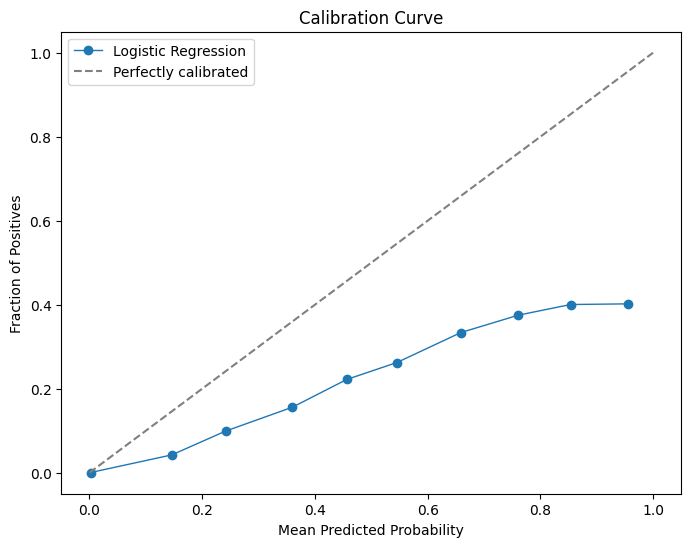

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Splitting the original training data into new training set and a calibration set
new_train_data, calib_data = train_test_split(training_data, test_size=0.2, random_state=42)

# Training the model on the new training set
probs = train_and_predict_two_halves(
    new_train_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_2Y',
    model=LogisticRegression(max_iter=400, random_state=42),
    augment_distribution=True,
    calibrate=True,
)

# Predicting on the calibration set
calib_probs = train_and_predict_two_halves(
    calib_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_2Y',
    model=LogisticRegression(max_iter=400, random_state=42),
    augment_distribution=True,
    calibrate=True,
)

# Getting the actual outcomes from the calibration set
y_actual = calib_data['TARGET_EVENT_BINARY_2Y']

# Generating the calibration curve
prob_true, prob_pred = calibration_curve(y_actual, calib_probs, n_bins=10)

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [67]:
def calibrated_expected(probas,mask, expected, logging=False):
    initial_guess = 2
    probas_unscaled = probas[mask].copy()
    new_proba = probas_unscaled.copy()
    while abs(new_proba.mean() - expected) > 0.00001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        error = new_proba.mean() - expected
        if error > 0:
            initial_guess += 0.001
        else:
            initial_guess -= 0.001
        if logging:
            print(error, initial_guess)

    return calculate_probabilities_vec(probas, initial_guess)

In [68]:
probs = training_data['PROBA_TO_2020']
new_proba = np.zeros(len(training_data))
mask_2016_h1 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2015-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2015-06-01') & (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2016_h2 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2015-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)


mask_2017_h1 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-06-01')& (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2017_h2 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')& (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2018_h1 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-06-01') & (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2018_h2 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2018-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)

proba_2016_h1 = probs
proba_2016_h2 = probs

proba_2017_h1 = probs
proba_2017_h2 = probs
proba_2018_h1 = probs
proba_2018_h2 = probs

print("Before scaling:")
print(proba_2016_h1[mask_2016_h1].mean(), proba_2016_h2[mask_2016_h2].mean())

print(proba_2017_h1[mask_2017_h1].mean(), proba_2017_h2[mask_2017_h2].mean())
print(proba_2018_h1[mask_2018_h1].mean(), proba_2018_h2[mask_2018_h2].mean())
print(probs.mean())

proba_2016_h1 = calibrated_expected(proba_2016_h1, mask_2016_h1, 0.005) # good 
proba_2016_h2 = calibrated_expected(proba_2016_h2, mask_2016_h2, 0.0055) # good

proba_2017_h1 = calibrated_expected(proba_2017_h1, mask_2017_h1, 0.0085)
proba_2017_h2 = calibrated_expected(proba_2017_h2, mask_2017_h2, 0.0105)
proba_2018_h1 = calibrated_expected(proba_2018_h1, mask_2018_h1, 0.016)
proba_2018_h2 = calibrated_expected(proba_2018_h2, mask_2018_h2, 0.0185)

print('Adter scaling:')
print(proba_2016_h1[mask_2016_h1].mean(), proba_2016_h2[mask_2016_h2].mean())
print(proba_2017_h1[mask_2017_h1].mean(), proba_2017_h2[mask_2017_h2].mean())
print(proba_2018_h1[mask_2018_h1].mean(), proba_2018_h2[mask_2018_h2].mean())
new_proba[mask_2016_h1] = proba_2016_h1[mask_2016_h1]
new_proba[mask_2016_h2] = proba_2016_h2[mask_2016_h2]
new_proba[mask_2017_h1] = proba_2017_h1[mask_2017_h1]
new_proba[mask_2017_h2] = proba_2017_h2[mask_2017_h2]
new_proba[mask_2018_h1] = proba_2018_h1[mask_2018_h1]
new_proba[mask_2018_h2] = proba_2018_h2[mask_2018_h2]
print(new_proba.mean())

Before scaling:
0.008780190980812263 0.008468227620371572
0.010229219126481821 0.012277598751439769
0.018354274610499297 0.01804149494763898
0.01662654344667736


Adter scaling:
0.005008484096619037 0.005508080109049804
0.008507207094923074 0.010506508069310949
0.01600569074104844 0.018498983605031397
0.011102653980925423


In [69]:
training_data['YEAR_SCALED_PROBA'] = new_proba

In [70]:
# REMOVING E HELPS!
allready_mature = 0
e_category = 0
guess = 0
matured_probas = []
for _, row in training_data.iterrows():

    if row['CONTRACT_MATURITY_DATE_DATETIME'] > pd.Timestamp('2020-01-01'):
        matured_probas.append( row['LOGISTIC_REG'])
    elif row['CONTRACT_MATURITY_DATE_DATETIME'] < pd.Timestamp('2018-01-01'):
        # matured_probas.append( row['LOGISTIC_REG'])
        if row['CONTRACT_REFINANCED'] != 2:
            matured_probas.append(0.0000000001)
            guess += 1
        else:
            matured_probas.append( row['LOGISTIC_REG'])
        allready_mature += 1
    elif row['TARGET_EVENT'] == 'E':
        # matured_probas.append( row['LOGISTIC_REG'])

        matured_probas.append(0.0000000001)
        e_category += 1
    else:
        # year_2018_date = pd.Timestamp('2018-01-01')
        # time_to_maturity = (row['CONTRACT_MATURITY_DATE_DATETIME'] - year_2018_date).days
        # # maybe linear interpolation?
        # ratio = time_to_maturity/730
        # # new_proba = calculate_probabilities_matured(row['LOGISTIC_REG'], time_to_maturity)
        # new_proba = row['LOGISTIC_REG'] * ratio
        # # print(time_to_maturity)
        # matured_probas.append( new_proba)
        matured_probas.append( row['LOGISTIC_REG'])
print(allready_mature)
print(e_category)
print(guess)

KeyboardInterrupt: 

In [ ]:
print(np.array(matured_probas).mean())
print(training_data['LOGISTIC_REG'].mean())

0.01436765358026898
0.015354264029913191


In [ ]:
# The reference probability withouth any removal: 0.014529438061794436
training_data['MATURED_PROBA'] = matured_probas
submission = create_submission_file(training_data, 'MATURED_PROBA', data_submission_example, filename='./predictions/2-percent-default.csv')

Before centering:
0.9999964927888196 7.649436639667329e-14 0.014606828430962764
Centering probabilities...
-0.0001931715690372364 1.999
-0.0001881929437368042 1.9980000000000002
-0.0001832106361259675 1.9970000000000003
-0.0001782246417889287 1.9960000000000004
-0.0001732349563023667 1.9950000000000006
-0.00016824157523536755 1.9940000000000007
-0.00016324449414944 1.9930000000000008
-0.00015824370859855025 1.9920000000000009
-0.00015323921412895881 1.991000000000001
-0.00014823100627934897 1.990000000000001
-0.0001432190805807504 1.9890000000000012
-0.00013820343255651311 1.9880000000000013
-0.00013318405772230063 1.9870000000000014
-0.0001281609515860864 1.9860000000000015
-0.00012313410964810874 1.9850000000000017
-0.000118103527400883 1.9840000000000018
-0.00011306920032916508 1.9830000000000019
-0.00010803112390993415 1.982000000000002
-0.00010298929361238045 1.981000000000002
-9.794370489790705e-05 1.9800000000000022
-9.289435322005352e-05 1.9790000000000023
-8.784123402454797e-0

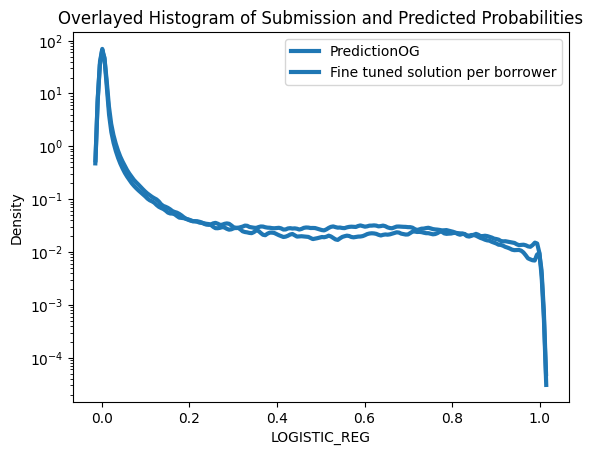

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
# sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
# sns.kdeplot(new_proba, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(submission, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

predicted_probs = 'MLP_REG'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=MLPClassifier(solver='lbfgs', activation='relu', alpha=1e-5,hidden_layer_sizes=(2,), random_state=1),
    augment_distribution=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# goal:0.023699439130050536

Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.02000649474503437
0.013633570962682626


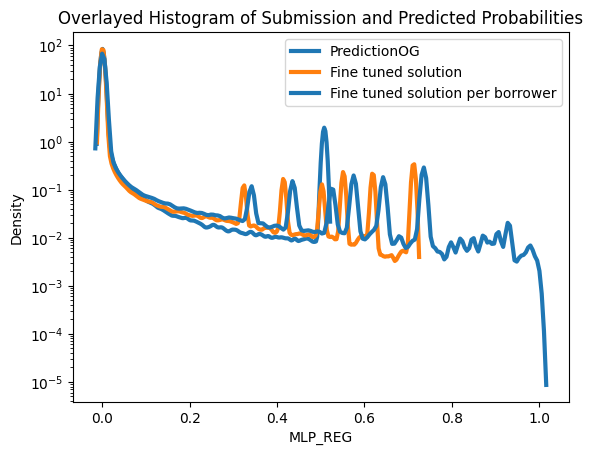

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
# sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['MLP_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(new_proba, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(submission, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:

new_proba = np.zeros(len(training_data))
mask_2016_h1 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2015-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2015-06-01') & (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2016_h2 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2015-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)


mask_2017_h1 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-06-01')& (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2017_h2 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')& (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2018_h1 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-06-01') & (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2018_h2 =  (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-06-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2018-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)

proba_2016_h1 = probs
proba_2016_h2 = probs

proba_2017_h1 = probs
proba_2017_h2 = probs
proba_2018_h1 = probs
proba_2018_h2 = probs

print("Before scaling:")
print(proba_2016_h1[mask_2016_h1].mean(), proba_2016_h2[mask_2016_h2].mean())

print(proba_2017_h1[mask_2017_h1].mean(), proba_2017_h2[mask_2017_h2].mean())
print(proba_2018_h1[mask_2018_h1].mean(), proba_2018_h2[mask_2018_h2].mean())
print(probs.mean())

proba_2016_h1 = calibrated_expected(proba_2016_h1, mask_2016_h1, 0.005) # good 
proba_2016_h2 = calibrated_expected(proba_2016_h2, mask_2016_h2, 0.0055) # good

proba_2017_h1 = calibrated_expected(proba_2017_h1, mask_2017_h1, 0.0085)
proba_2017_h2 = calibrated_expected(proba_2017_h2, mask_2017_h2, 0.0105)
proba_2018_h1 = calibrated_expected(proba_2018_h1, mask_2018_h1, 0.016)
proba_2018_h2 = calibrated_expected(proba_2018_h2, mask_2018_h2, 0.0185)

print('Adter scaling:')
print(proba_2016_h1[mask_2016_h1].mean(), proba_2016_h2[mask_2016_h2].mean())
print(proba_2017_h1[mask_2017_h1].mean(), proba_2017_h2[mask_2017_h2].mean())
print(proba_2018_h1[mask_2018_h1].mean(), proba_2018_h2[mask_2018_h2].mean())
new_proba[mask_2016_h1] = proba_2016_h1[mask_2016_h1]
new_proba[mask_2016_h2] = proba_2016_h2[mask_2016_h2]
new_proba[mask_2017_h1] = proba_2017_h1[mask_2017_h1]
new_proba[mask_2017_h2] = proba_2017_h2[mask_2017_h2]
new_proba[mask_2018_h1] = proba_2018_h1[mask_2018_h1]
new_proba[mask_2018_h2] = proba_2018_h2[mask_2018_h2]
print(new_proba.mean())

Before scaling:
0.008695423687674607 0.0073968683638413815
0.009283727050692558 0.010340806430361591
0.013891756938589602 0.0137070124427338
0.01387576679915962
Adter scaling:
0.005008817188118286 0.005507016521021084
0.008506379294725615 0.010497077116986513
0.016002274396049718 0.01849938888325098
0.01110005690450756


In [ ]:
training_data['MLP_PROBA'] = new_proba
submission = create_submission_file(training_data, 'MLP_PROBA', data_submission_example, filename='./predictions/mlp-25.csv')

Before centering:
0.9999999911739428 2.834933385820193e-07 0.01419702277849689
Centering probabilities...
-0.0006029772215031103 1.999
-0.0005984249601666217 1.9980000000000002
-0.000593869802415388 1.9970000000000003
-0.0005893117455139547 1.9960000000000004
-0.0005847507867234262 1.9950000000000006
-0.0005801869233015167 1.9940000000000007
-0.0005756201525024731 1.9930000000000008
-0.0005710504715771315 1.9920000000000009
-0.0005664778777729178 1.991000000000001
-0.0005619023683337762 1.990000000000001
-0.0005573239405002248 1.9890000000000012
-0.0005527425915093313 1.9880000000000013
-0.0005481583185947114 1.9870000000000014
-0.0005435711189864662 1.9860000000000015
-0.0005389809899113349 1.9850000000000017
-0.0005343879285924745 1.9840000000000018
-0.0005297919322496212 1.9830000000000019
-0.0005251929980990278 1.982000000000002
-0.0005205911233534168 1.981000000000002
-0.0005159863052220694 1.9800000000000022
-0.0005113785409107188 1.9790000000000023
-0.000506767827621624 1.978000

In [ ]:
odds = adjust_probabilities(training_data['LOGISTIC_REG'],  0.95)
print(odds.mean())

0.0147349012896156


In [ ]:
# odds = adjust_probabilities(training_data['LOGISTIC_REG'],  2.5)
print(odds.mean())
training_data['ODDS_PROBA'] = odds
submission = create_submission_file(training_data, 'ODDS_PROBA', data_submission_example, filename='./predictions/logistic-regression-one-model.csv')

0.0147349012896156
Before centering:
0.9999769399588031 3.1530333899354446e-14 0.014916735257327797
Centering probabilities...
0.00011673525732779251 2.001
0.0001114951884763505 2.002
0.00010625902095234147 2.0029999999999997
0.0001010267501148545 2.0039999999999996
9.579837133082136e-05 2.0049999999999994
9.057387997496447e-05 2.0059999999999993
8.53532714297986e-05 2.0069999999999992
8.013654108557887e-05 2.007999999999999
7.492368434035626e-05 2.008999999999999
6.971469659985963e-05 2.009999999999999
6.450957327758071e-05 2.010999999999999
5.9308309794676994e-05 2.0119999999999987
5.41109015800012e-05 2.0129999999999986
4.891734407005792e-05 2.0139999999999985
4.372763270901747e-05 2.0149999999999983
3.8541762948672564e-05 2.0159999999999982
3.3359730248424396e-05 2.016999999999998
2.818153007526185e-05 2.017999999999998
2.3007157903784034e-05 2.018999999999998
1.783660921612397e-05 2.019999999999998
1.2669879501978065e-05 2.0209999999999977
7.506964258571433e-06 2.0219999999999976


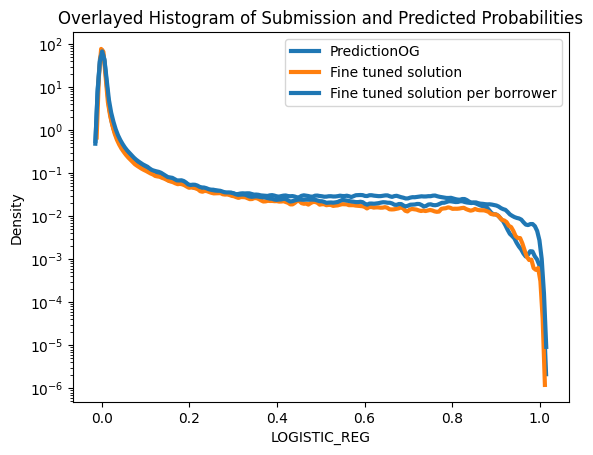

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
# sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(new_proba, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(submission, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import numpy as np

# Other necessary imports, like pandas, if you're using a DataFrame

def train_and_evaluate(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), cv_folds=5, augment_distribution=False):
    # Your lognormal_variables transformation code remains the same
    if lognormal_variables is not None:
        df = df.copy()
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    # Split the data before the given date for training 
    if augment_distribution:
        df_filtered = default_percentage_generator_2016(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    X_filtered = df_filtered[variables]
    y_filtered = df_filtered[target]
    
    # Scale the filtered features
    X_filtered_scaled = scaler.fit_transform(X_filtered)
    
    # Perform cross-validation and fit the model
    cv_scores = cross_val_score(model, X_filtered_scaled, y_filtered, cv=cv_folds, scoring='neg_log_loss')
    
    print(f"CV Log Loss Scores: {-cv_scores}")
    print(f"Mean CV Log Loss: {-np.mean(cv_scores)}")
    
    # Now fit the model to the entire dataset
    model.fit(X_filtered_scaled, y_filtered)
    
    # Scale the entire dataset to predict probabilities for all records
    X_scaled = scaler.transform(df[variables])
    
    # Predict probabilities using the trained model
    proba = model.predict_proba(X_scaled)[:, 1]

    # Calculate log loss on the full dataset
    full_log_loss = log_loss(df[target], proba)

    print(f"Full Dataset Log Loss: {full_log_loss}")

    return proba, cv_scores, full_log_loss

# You might call the function like this
# probabilities, cv_scores, full_log_loss = train_and_evaluate(df, variables, target)



In [ ]:
# BASELINE: 0.023855179491479847
predicted_probs = 'XGBOOST'
probs, _, _ = train_and_evaluate(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=MLPClassifier(solver='lbfgs', activation='logistic', alpha=1e-5,hidden_layer_sizes=(40,), random_state=1),
    augment_distribution=True
)
training_data[predicted_probs] = probs
print(probs.mean())

Mean in year 0.011345816067598232
5206
1750.5931790499392
CV Log Loss Scores: [0.01686782 0.01749462 0.01814515 0.01667165 0.01580408]
Mean CV Log Loss: 0.01699666309210896
Full Dataset Log Loss: 0.018103399268726995
0.011900505063732275


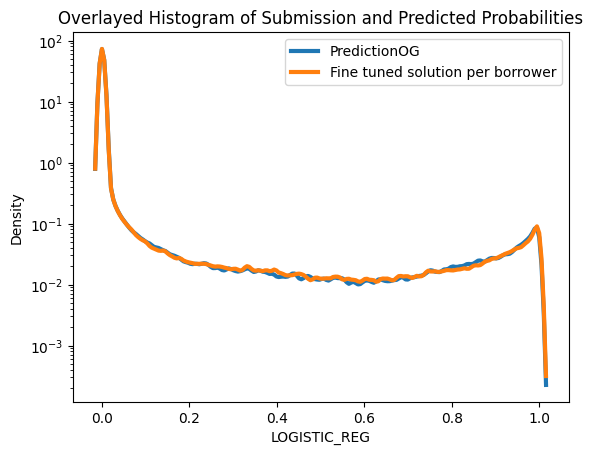

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
# sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
# sns.kdeplot(experiment_probs, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(training_data['XGBOOST'], label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:
magic_number = 1.6
experiment_probs = calculate_probabilities(training_data, 'XGBOOST', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())


0.012484113731198196 0.9992862747843598 1.490116185998147e-07 0.0915481464181552


In [ ]:
# training_data['EXPERIMENT_PROBS_XGB'] = experiment_probs
submission_exp = create_submission_file(training_data, 'XGBOOST', data_submission_example, filename='./predictions/xgb-prediction-with-time-param-0-585.csv')

KeyError: 'Column not found: XGBOOST'

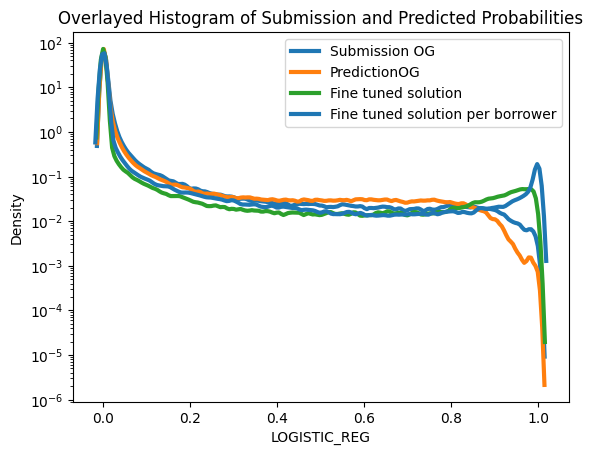

In [ ]:
condition = (submission_exp['PRED'] > 0.9999)# | (submission_exp['PRED'] < 0.01)
ensemble_submission = submission.copy()
ensemble_submission.loc[condition,'PRED'] = submission_exp.loc[condition,'PRED']

In [ ]:
condition.sum()

902

In [ ]:
ensemble_submission['PRED'].mean()  

0.01494954796107231

In [ ]:
calculate_probabilities_vec(ensemble_submission['PRED'].values, 2.029).mean()

0.014804265269186677

In [ ]:
ensemble_submission['PRED'] = calculate_probabilities_vec(ensemble_submission['PRED'].values, 2.029)

In [ ]:
ensemble_submission.to_csv('./predictions/ensemble-submission.csv', index=False)

In [ ]:
ensemble_submission.head(5)

,BORROWER_ID,PRED
0,+++b/oYx,1.969608e-04
1,+++pcjqH,2.220974e-04
2,+++ukYrT,3.286332e-07
3,+++wvYn7,1.951255e-03
4,++/6JzSJ,1.506098e-02


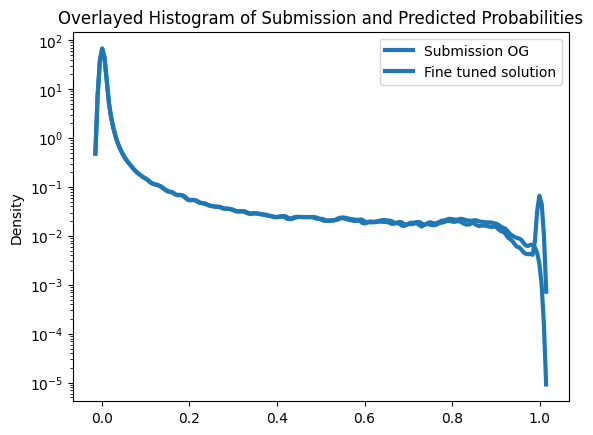

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1, color='r')
# sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(ensemble_submission, label='Fine tuned solution', lw=3, alpha=1, color='g')
# sns.kdeplot(submission_exp, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:
# 3as ikrek: nPLESJ1	xnQn5C/o	1d42bbf5	2	1498	31	2457102	15,6	479a2e13	411232	14504	13150	48	6,23	626802	636105	12	80,71	1f951336	4581572	2458574	3715405	4	2	0,96	100003	1254	98	98	122	A	3	-	
# nPLESJ1	q4Rw0xr/	1d42bbf5	2	1498	31	2457102	15,6	479a2e13	411232	14504	13150	48	6,23	626802	636105	12	80,71	1f951336	4581572	2458574	3715405	4	2	0,96	100003	1254	98	98	122	B	3	-	
# nPLESJ1	p1Hxyyah	1d42bbf5	2	1498	31	2457102	15,6	479a2e13	411232	14504	13150	48	6,23	626802	636105	12	80,71	1f951336	4581572	2458574	3715405	4	2	0,96	100003	1254	98	98	122	B	3	-	
